In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [4]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40018
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

# Define reference and query

In [6]:
# reference
scrna_ref = scrna[:7000]
scatac_ref = scatac[:7000]

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
# query
scrna_query = scrna[7000:]
scatac_query = scatac[7000:]

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# Configure and train the model

To configure the model, we need to specify the following parameters:
   - pair_groups = whether the dtaa is paired or not; if the data is paired same number should be passed, e.g. [[0], [0]] or [[1], [1]], if not paired then different numbers, e.g. [[0], [1]]
   - condition = whether the model is cVAE and which version: '0' for adding only batch labels, '1' for adding batch labels and modality labels. Has to be conditional for query to reference. Has to be one of ['0', '1', None].
   - z_dim = number of dimentions in the latent space
   - h_dim = number of dimentions in the hidden space, i.e. output dimention of the modality encoders and input dimention of the shared encoder
   - hiddens = dimentionality of hidden layers in modality encoders/decoders; e.g. if hiddens = [[512], [1024]] then the input dimentions of modality encoders would be 3999 -> 512 -> 128 for rna and 40018 -> 1024 -> 128 for atac.
   - output actiations = activation funtions of the last layer of modelity decoders; has to be one of ['linear', 'relu', 'leakyrelu', 'sigmoid']
   - shared_hiddens = dimentionality of hidden layers in the shared encoder/decoder; e.g. if shared_hiddens = [64], then the input dimentions of the shared encoder would be 128 -> 64 -> 20
   - recon_coef = reconstruction coefficient, i.e. the weight of MSE reconstruction loss in the total loss (the higher the more important)
   - kl_coef = KL-divergence loss coefficient
   - cycle_coef = cycle consistency loss coefficient.
   
Additionally, adatas, names, pair_groups and hiddens should have the same number of modalities and the same length per modality.

In [8]:
model = mtg.models.MultiVAE(
    adatas=[[scrna_ref], [scatac_ref]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    condition='1',
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-4,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [9]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=5000,
    validate_every=1000
)

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 |██------------------| 10.0% iter=1001/10000, time=342.01(s), loss=0.3283, recon=0.2549, kl=34.4675, integ=7.2859, val_loss=0.2674, val_recon=0.2172, val_kl=43.9084, val_integ=4.9350
 |████----------------| 20.0% iter=2001/10000, time=380.16(s), loss=0.2516, recon=0.2241, kl=60.8677, integ=2.5518, val_loss=0.2426, val_recon=0.2146, val_kl=57.0254, val_integ=2.5719
 |██████--------------| 30.0% iter=3001/10000, time=371.23(s), loss=0.2312, recon=0.2168, kl=72.2901, integ=1.0608, val_loss=0.2326, val_recon=0.2135, val_kl=65.8514, val_integ=1.5175
 |████████------------| 40.0% iter=4001/10000, time=358.50(s), loss=0.2268, recon=0.2144, kl=75.4196, integ=0.6990, val_loss=0.2293, val_recon=0.2120, val_kl=66.6166, val_integ=1.2020
 |██████████----------| 50.0% iter=5001/10000, time=357.48(s), loss=0.2277, recon=0.2159, kl=70.3931, integ=0.5333, val_loss=0.2265, val_recon=0.2122, val_kl=61.0770, val_integ=0.8209
 |████████████--------| 60.0% iter=6001/10000, time=326.22(s), loss=0.2223, reco

## Plot training history

In [10]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,val_loss,val_recon,val_kl,val_integ
0,1000,0.328260,0.254923,34.467548,7.285925,0.267420,0.217192,43.908440,4.934950
1,2000,0.251617,0.224122,60.867741,2.551789,0.242572,0.214573,57.025440,2.571882
2,3000,0.231194,0.216813,72.290054,1.060774,0.232648,0.213522,65.851429,1.517492
3,4000,0.226815,0.214391,75.419553,0.699010,0.229337,0.211988,66.616610,1.201967
4,5000,0.227687,0.215889,70.393105,0.533314,0.226499,0.212182,61.076961,0.820873
5,6000,0.222289,0.211720,63.911722,0.417783,0.222483,0.211259,57.302991,0.549438
6,7000,0.224697,0.215166,59.414375,0.358913,0.219714,0.210243,56.064749,0.386438
7,8000,0.221049,0.212298,58.921709,0.285891,0.217940,0.209543,56.075447,0.278871
8,9000,0.224017,0.215784,56.671918,0.256607,0.216124,0.208453,55.696038,0.210223
9,9999,0.218484,0.210557,56.892926,0.223772,0.215351,0.208129,55.062303,0.171537


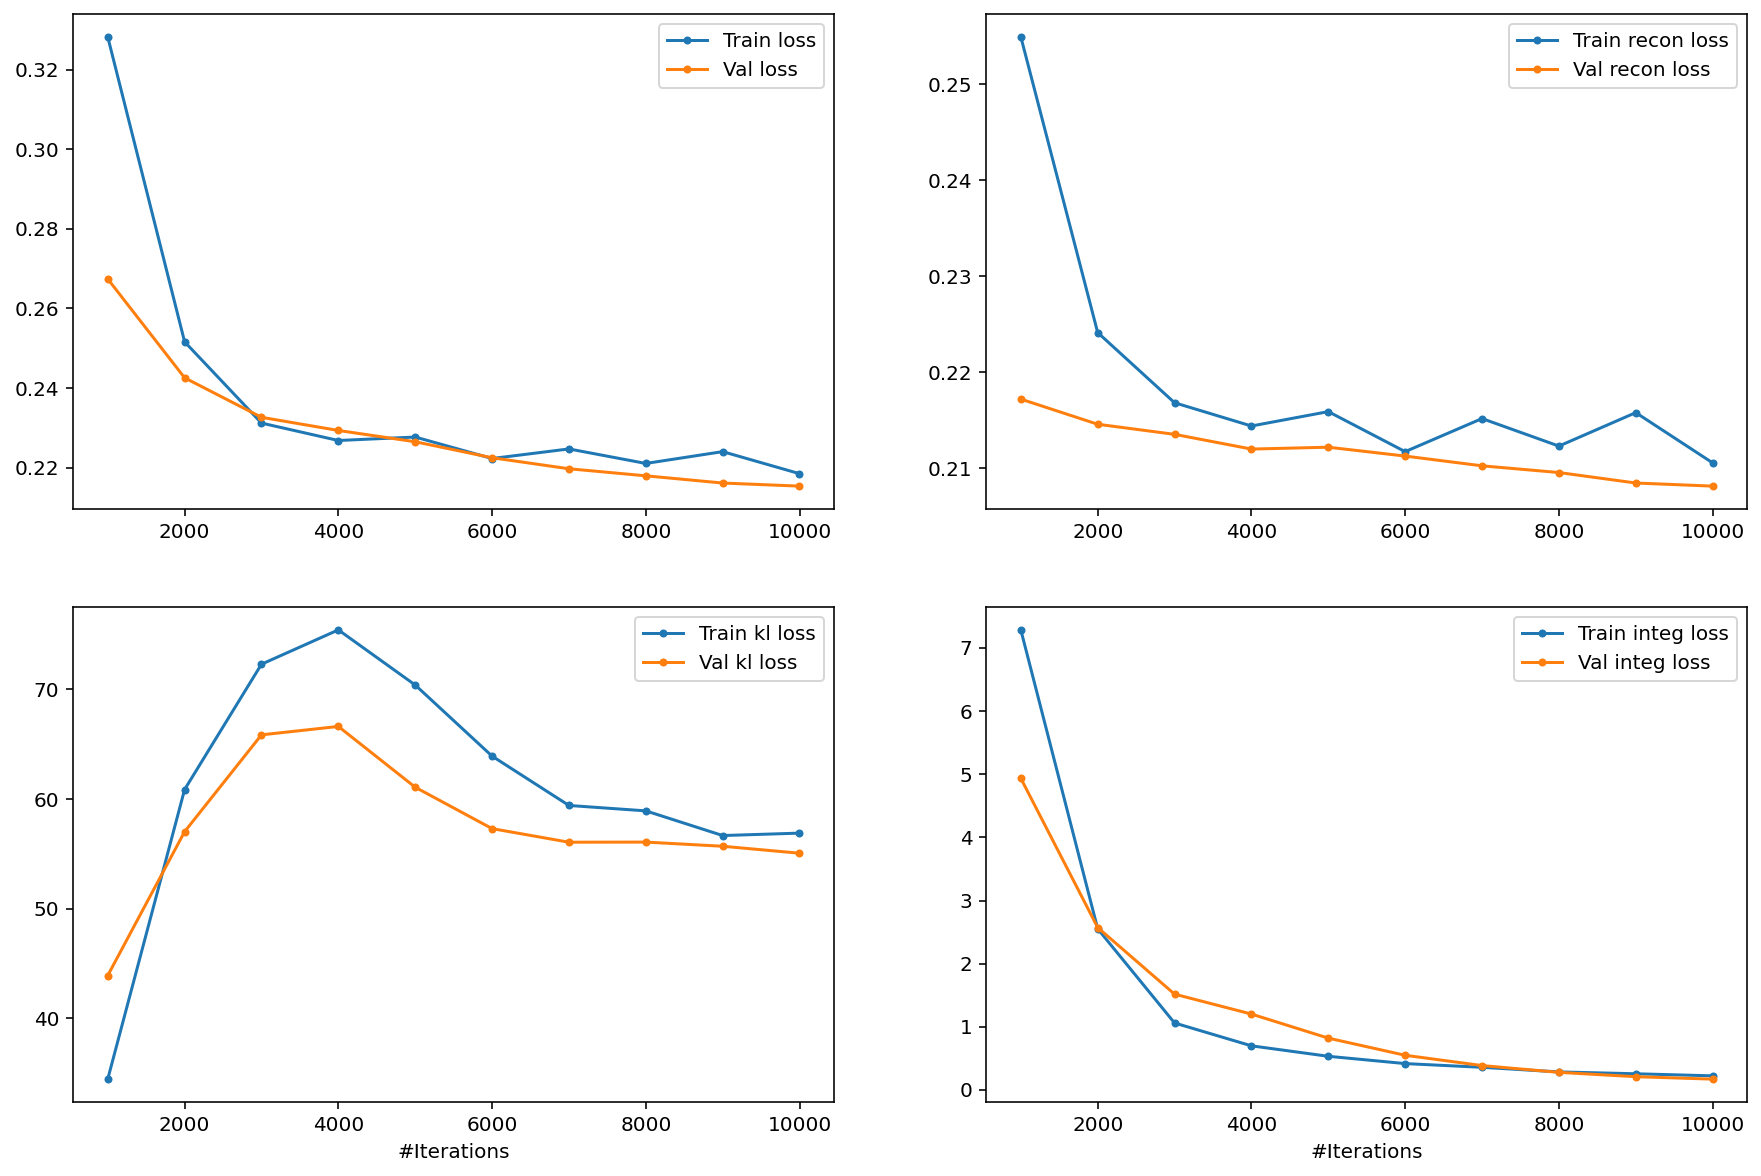

In [11]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

### UMAP plot of the latent space

In [12]:
z = model.predict(
    adatas=[[scrna_ref], [scatac_ref]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 14000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [13]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


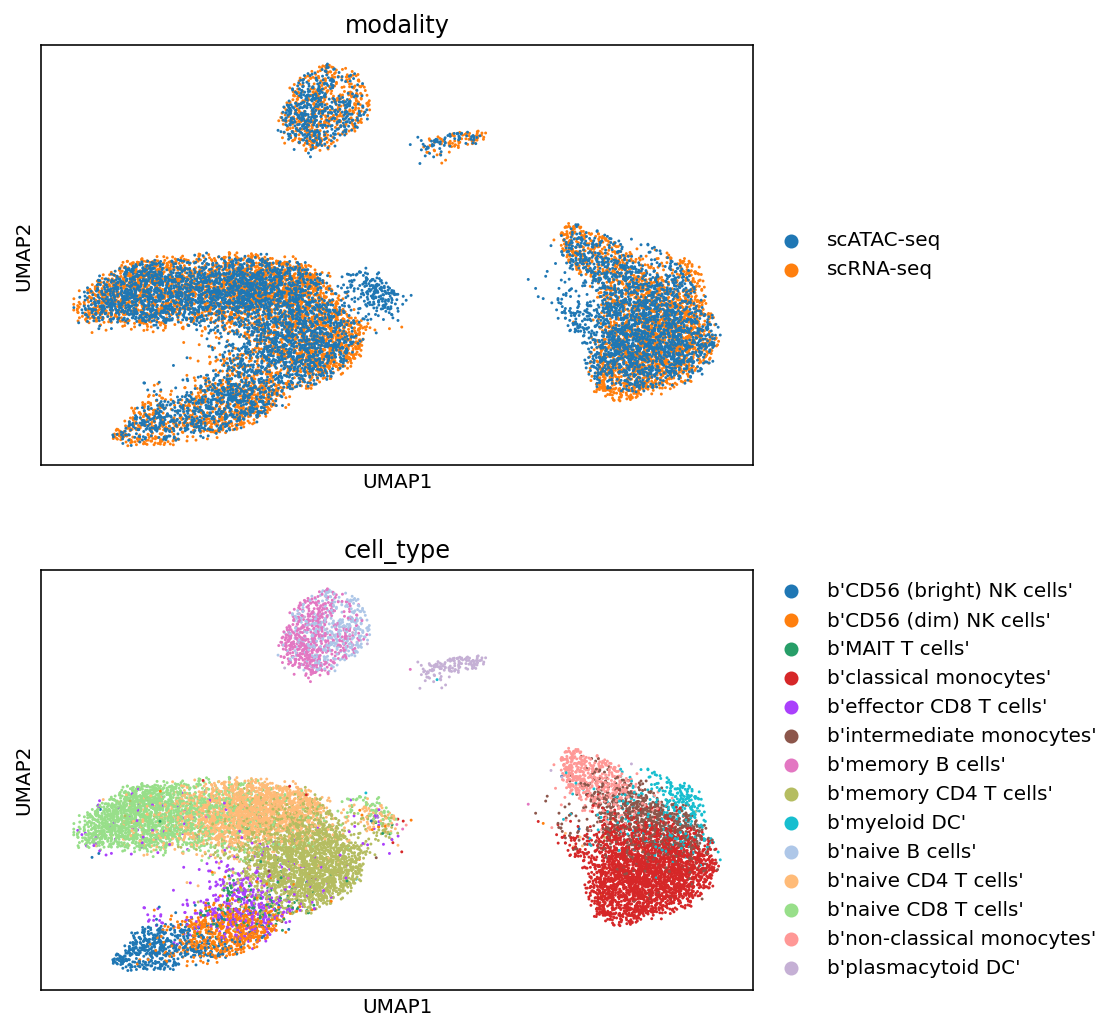

In [14]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

# Query new data

We operate on the old model to add new batch labels. When you first train a model on lets say [[rna1, rna2], [atac1]] adatas, then internally batch labels are [[0, 1], [0]], i.e. the numeration starts with 0 and is independent of the modality and if the data is paired or not.

When we add new datasets, say [[rna3], [atac2]] the new batch labels for this data are [[2], [1]]. We need to keep track of it for later inference.

In this example, batch labels corresponding to [[scrna_ref, scrna_query], [scatac_ref, scatac_query]] are [[0, 1], [0, 1]].

In operate, we again need adatas, names and pair_groups have the same number of modalities and the same length per modality. Also even if we are adding to only one modality, e.g. adatas=[[scrna_query], []], number of modalities should be same as in the original model.

fine_tune parameter indicats if we want to fine-tune the first layer of the changed modality encoders/decoders or only newly added conditional weights, has to be either 'cond_weights' or 'first_layer'.

In [15]:
new_model = mtg.operate(model, 
                   adatas=[[scrna_query],[scatac_query]],
                    names=[['scRNA-seq-query'], ['scATAC-seq-query']],
                    pair_groups=[[0],[0]],
                    fine_tune='cond_weights')

In [16]:
new_model.train(
    n_iters=2000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=1000
)

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 |██████████----------| 50.0% iter=1001/2000, time=267.86(s), loss=0.2233, recon=0.2181, kl=56.4214, integ=0.2272, val_loss=0.2179, val_recon=0.2106, val_kl=55.8652, val_integ=0.1731
 |████████████████████| 100.0% iter=2000/2000, time=269.25(s), loss=0.2218, recon=0.2139, kl=56.8050, integ=0.2222, val_loss=0.2167, val_recon=0.2094, val_kl=55.8319, val_integ=0.1712


First predict only on query data. Note that we specify the corresponding batch_labels here.

In [17]:
z = new_model.predict(
    adatas=[[scrna_query], [scatac_query]],
    names=[['scRNA-seq-query'], ['scATAC-seq-query']],
    batch_labels=[[1], [1]], #same as in train
    batch_size=64,
)
z

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 6000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [18]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


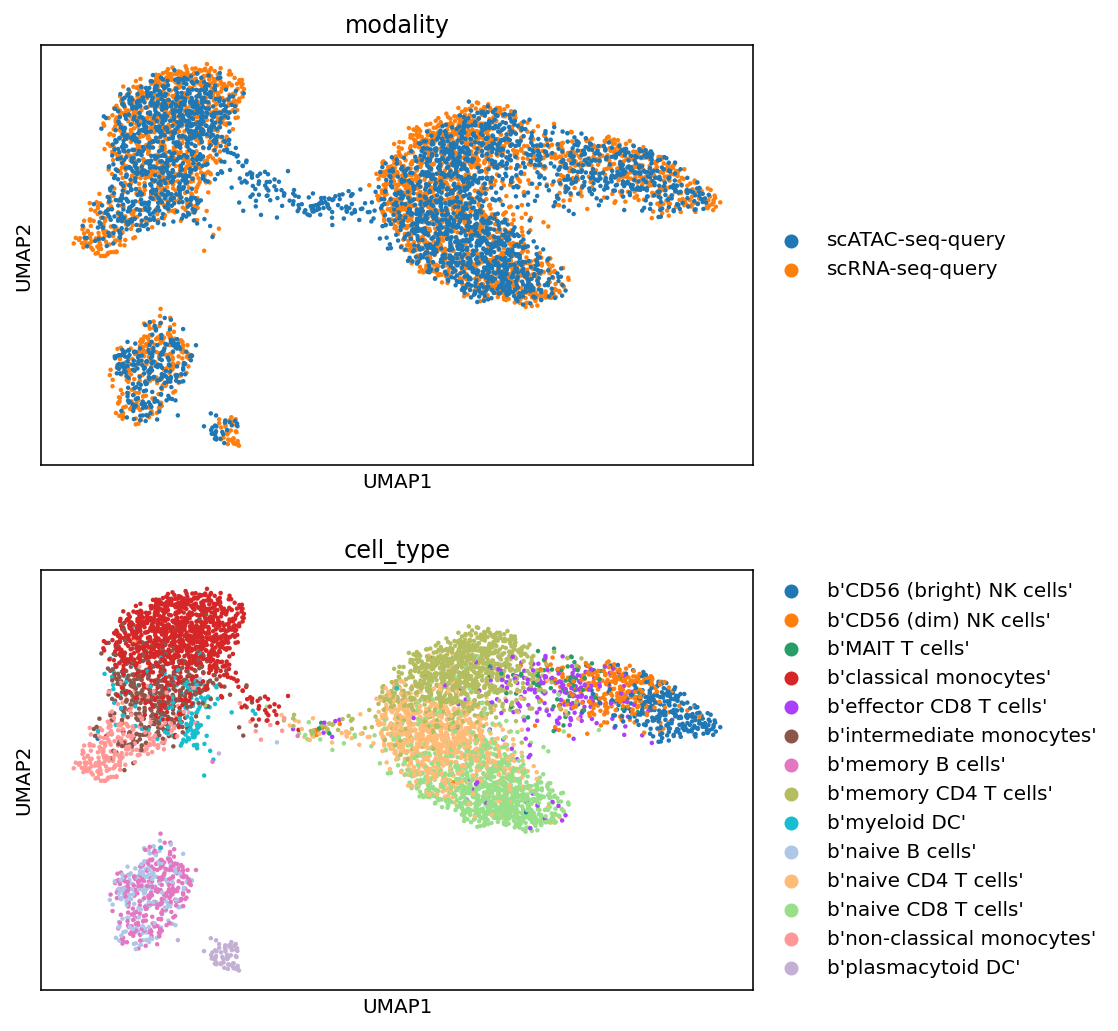

In [19]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

Now, use both reference and query data.

In [20]:
z = new_model.predict(
    adatas=[[scrna_ref, scrna_query], [scatac_ref, scatac_query]],
    names=[['scRNA-seq-ref', 'scRNA-seq-query'], ['scATAC-seq-ref', 'scATAC-seq-query']],
    batch_labels=[[0, 1], [0, 1]], #same as in train
    batch_size=64,
)
z

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 20000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [21]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


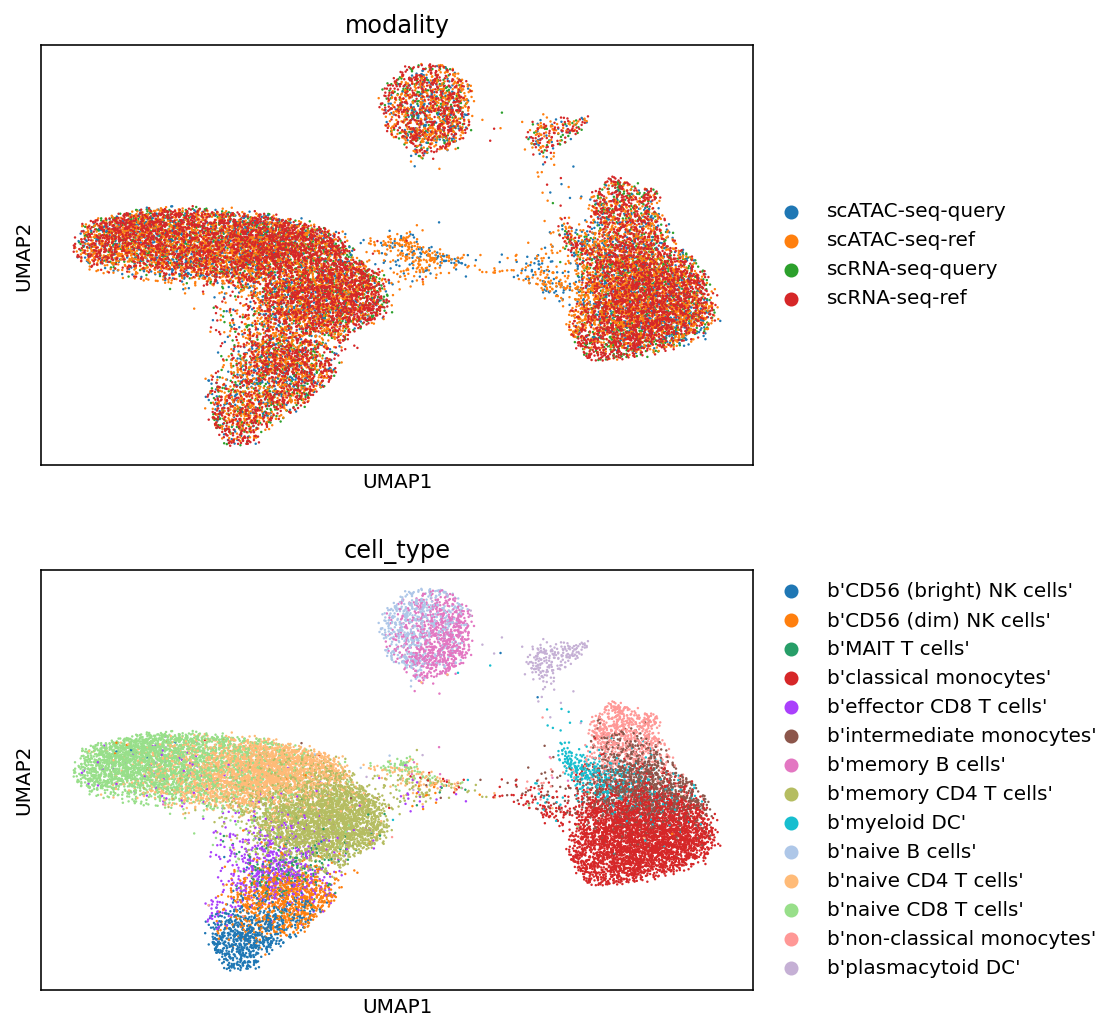

In [22]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

# Metrics

We use metrics from scIB (https://github.com/theislab/scib). You can either import scIB module or use mtg.metrics.metrics() which give the same result. We use PCR, batch ASW and graph connectivity from batch removal metrics and NMI, ARI, cell type ASW and isolated label score ASW from biological conservation metrics. You can find more details on the metrics in the scIB paper (https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2).

In [23]:
z.obs.modality = z.obs.modality.astype('category')
z.obs.cell_type = z.obs.cell_type.astype('category')

We need not_integrated_adata only if using PCR. If not pass z two times to metrics.metrics().

In [24]:
scrna_ref.obs_names = scrna_ref.obs_names.astype(str)
scrna_ref.var_names = scrna_ref.var_names.astype(str)
scatac_ref.obs_names = scatac_ref.obs_names.astype(str)
scatac_ref.var_names = scatac_ref.var_names.astype(str)

scrna_ref.obs['modality'] = 'scRNA-seq'
scatac_ref.obs['modality'] = 'scATAC-seq'

not_integrated_adata = sc.AnnData.concatenate(scrna_ref, scatac_ref, join='outer')

In [27]:
import scIB as scib

if 'X_pca' not in z.obsm.keys():
    sc.tl.pca(z)

metrics = scib.metrics.metrics(
    not_integrated_adata, z,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
    pcr_=True,
    isolated_labels_=True,
    graph_conn_=True,
)
metrics

clustering...


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitin

NMI...
ARI...
silhouette score...


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
 

PC regression...
isolated labels...


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


Graph connectivity...


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scIB/metrics.py:1746: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  _,labs = connected_components(adata_post_sub.uns['neighbors']['connectivities'], connection='strong')


,0
NMI_cluster/label,0.677291
ARI_cluster/label,0.555771
ASW_label,0.533297
ASW_label/batch,0.971641
PCR_batch,0.999026
cell_cycle_conservation,NaN
isolated_label_F1,0.645734
isolated_label_silhouette,0.548272
graph_conn,0.956696
kBET,NaN


In [36]:
metrics = mtg.metrics.metrics(not_integrated_adata, 
    z,
    batch_key='modality',
    label_key='cell_type',
    name='10x-pbmc',                          
    save='../data/10xpbmc10k-2020/metrics.csv'
)
metrics

Clustering...


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitin

ASW label/batch...


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
 

PCR batch...
Graph connectivity...
ASW label...


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/alitinet/Desktop/thesis/multigrate/multigrate/metrics.py:548: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  _,labs = connected_components(adata_post_sub.uns['neighbors']['connectivities'], connection='strong')


NMI cluster/label...
ARI cluster/label...
Isolated label silhouette...


,score
ASW_label/batch,0.971641
PCR_batch,0.999026
graph_conn,0.956696
ASW_label,0.533297
NMI_cluster/label,0.677291
ARI_cluster/label,0.555771
isolated_label_silhouette,0.548272
